# Thesis Section 5.6: What Characterised FE Debate

This notebook will walk through the analyses discussed in section 5.6 of the Thesis.
Key features will be identified that separate posts from the FE and off-topic sections of the FES forum.

## Table of contents
<div id="toc"></div>

In [1]:
# -*- coding: utf-8 -*-

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
import numpy as np
import seaborn as sns
import sqlite3
import sys

sys.path.insert(1, "../")
sys.path.insert(1, "../utilities")

from language_change_methods.utility_functions import tokenise, get_time_windows, get_data_windows, count_tokens
from language_change_methods.cross_entropy import single_CE_run

from helpers import load_posts, load_toks, load_pos, load_ent

GRAPH_DIR = "./Graphs"

## Load in the data

In [5]:
def read_db(db_fp, query):
    conn = sqlite3.connect(db_fp)
    comments = pd.read_sql_query(query, conn, index_col="uid", parse_dates={"time": "%Y/%m/%d %H:%M:%S"})
    comments.index = comments.index.astype(str)
    comments.sort_values("time", inplace=True)
    return comments


def get_align_toks(tok_fp, posts):
    # Get the corresponding tokens
    toks = {x[0]: x[1] for x in load_toks(tok_fp)}
    toks = pd.Series(toks)
    toks = toks[toks.index.isin(posts.index)]

    # Remove the posts that don't have tokens
    posts = posts[posts.index.isin(toks.index)]
    # Align the ordering of forum posts and toks
    toks = toks.loc[posts.index]

    return toks, posts

In [4]:
from settings import TFES_FP as FORUM_DB_FP, TFES_TOK_FP as FORUM_TOKS_FP
from helpers import flat_earth_boards, off_topic_boards as other_boards

sql_get_forum ="""
                SELECT p.uid AS uid, p.time AS time, p.user AS poster_id, b.uid AS board_id
                FROM posts as p
                INNER JOIN topics as t
                ON t.uid = p.topic
                INNER JOIN boards as b
                ON b.uid = t.board;""".strip()

In [7]:
%%time
# Gets all flat earth posts
forum_posts = read_db(FORUM_DB_FP, sql_get_forum)

forum_toks, forum_posts = get_align_toks(FORUM_TOKS_FP, forum_posts)

fe_posts = forum_posts.query("board_id in @flat_earth_boards")
ot_posts = forum_posts.query("board_id in @other_boards")

Wall time: 19.7 s


## Keywords

In [8]:
%%time
from features import get_ngram_lr_and_ll

fe_kw = get_ngram_lr_and_ll(forum_toks.loc[fe_posts.index], forum_toks.loc[ot_posts.index], 1, "_")
# fe_kw = fe_kw.query("LL > 3.84 and LR > 1 and freq1 > 100")

Wall time: 10.7 s


#### Number of Keywords that satisfy cutoff

In [9]:
print("{} keywords".format(len(fe_kw.query("LL > 3.84 and LR > 1 and freq1 > 100"))))

1442 keywords


#### Top 20 FE Keywords

In [10]:
fe_kw.sort_values("LR", ascending=False).head(20)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
longitude,1075,0,9.939833,808.643780,6752856,3083437
circumference,718,0,9.357886,540.098822,6752856,3083437
refraction,2177,2,8.635570,1610.265758,6752856,3083437
mirage,357,0,8.350841,268.544958,6752856,3083437
mercator,330,0,8.237548,248.234835,6752856,3083437
saros,311,0,8.152130,233.942526,6752856,3083437
santiago,305,0,8.124070,229.429165,6752856,3083437
equinox,839,1,7.997466,617.972717,6752856,3083437
clockwise,274,0,7.969704,206.110135,6752856,3083437


#### Top 20 off-topic keywords

In [11]:
fe_kw.sort_values("LR", ascending=True).head(20)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
morrowind,0,391,-10.743827,907.146610,6752856,3083437
biden,0,378,-10.695108,876.985726,6752856,3083437
skyrim,0,340,-10.542469,788.823139,6752856,3083437
snupes,0,322,-10.464114,747.061914,6752856,3083437
zappa,0,297,-10.347704,689.060213,6752856,3083437
gilmour,0,263,-10.172618,610.177899,6752856,3083437
bethesda,0,262,-10.167132,607.857831,6752856,3083437
blm,0,205,-9.813953,475.613952,6752856,3083437
gop,0,200,-9.778417,464.013611,6752856,3083437


#### FE keywords that are common in off-topic

In [12]:
fe_kw.query("freq1 > 500 and freq2 > 500").sort_values("LR", ascending=False).head(20)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
flat,28940,672,4.296453,16911.945850,6752856,3083437
earth,55822,1579,4.012348,31192.483040,6752856,3083437
light,9540,664,2.712765,3804.513816,6752856,3083437
space,7998,753,2.277092,2630.053174,6752856,3083437
science,4874,515,2.110251,1463.664945,6752856,3083437
tom,4897,533,2.067527,1433.999928,6752856,3083437
line,5713,672,1.955810,1559.957016,6752856,3083437
evidence,10759,1499,1.712099,2464.325382,6752856,3083437
force,4452,647,1.650705,970.402146,6752856,3083437


#### Off-topic keywords that appear in FE

In [13]:
fe_kw.query("freq1 > 500 and freq2 > 500").sort_values("LR", ascending=True).head(20)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
her,503,2140,-3.218843,2770.735793,6752856,3083437
she,635,2455,-3.081011,3034.390680,6752856,3083437
bad,862,2301,-2.546937,2281.408787,6752856,3083437
story,637,1651,-2.504238,1603.150874,6752856,3083437
him,2177,4481,-2.172267,3617.901598,6752856,3083437
fun,515,876,-1.896740,586.210775,6752856,3083437
black,733,1238,-1.886683,822.083109,6752856,3083437
yeah,931,1555,-1.870709,1020.016279,6752856,3083437
god,1841,3063,-1.865258,2000.565883,6752856,3083437


## Word N-Grams

We'll now find some key ngrams with varying values of N

### Bigrams

In [14]:
%%time
fe_kw_2 = get_ngram_lr_and_ll(forum_toks.loc[fe_posts.index], forum_toks.loc[ot_posts.index], 2, "_")

Wall time: 27.7 s


#### Key for FE

In [15]:
fe_kw_2.sort_values("LR", ascending=False).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
southern_hemisphere,940,0,9.721769,697.120363,5776496,2593103
perspective_lines,475,0,8.737786,352.268268,5776496,2593103
flight_times,466,0,8.710218,345.593712,5776496,2593103
fe_map,425,0,8.577500,315.187398,5776496,2593103
shadow_object,399,0,8.486537,295.905346,5776496,2593103
the_equinox,389,0,8.449964,288.489171,5776496,2593103
at_eye,369,0,8.373915,273.656823,5776496,2593103
tropic_of,353,0,8.310051,261.790945,5776496,2593103
circumference_of,350,0,8.297756,259.566093,5776496,2593103


#### Key for off-topic

In [16]:
fe_kw_2.sort_values("LR", ascending=True).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
dark_souls,0,177,-9.627190,414.799764,5776496,2593103
the_democrats,0,167,-9.543532,391.364749,5776496,2593103
trump_was,0,151,-9.398689,353.868725,5776496,2593103
the_gop,0,137,-9.258803,321.059704,5776496,2593103
the_album,1,396,-9.201730,914.802857,5776496,2593103
with_trump,0,121,-9.080328,283.563681,5776496,2593103
this_song,0,112,-8.969296,262.472167,5776496,2593103
israel_is,0,112,-8.969296,262.472167,5776496,2593103
about_trump,0,106,-8.890225,248.411158,5776496,2593103


#### Common Key for FE

In [17]:
fe_kw_2.query("freq1 > 100 and freq2 > 100").sort_values("LR", ascending=False).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
the_sun,18904,253,5.065085,11920.318247,5776496,2593103
a_flat,6489,109,4.733589,3957.115789,5776496,2593103
flat_earth,15221,293,4.541091,9068.348561,5776496,2593103
the_moon,9769,215,4.347010,5672.993321,5776496,2593103
earth_is,9080,239,4.089159,5071.085627,5776496,2593103
the_earth,25061,670,4.068577,13944.865916,5776496,2593103
the_sky,2763,112,3.462985,1365.032747,5776496,2593103
the_light,2095,110,3.089661,937.494226,5776496,2593103
to_explain,2118,173,2.454520,749.702566,5776496,2593103


#### Common Key for Off-Topic

In [18]:
fe_kw_2.query("freq1 > 100 and freq2 > 100").sort_values("LR", ascending=True).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
the_story,137,620,-3.329515,838.643471,5776496,2593103
the_media,113,481,-3.240359,632.988314,5776496,2593103
the_state,108,345,-2.826506,390.990422,5776496,2593103
a_bad,157,393,-2.476527,379.595451,5776496,2593103
to_pay,104,260,-2.473296,250.898338,5776496,2593103
i_love,147,365,-2.464672,350.463636,5776496,2593103
gon_na,208,441,-2.237881,373.582334,5776496,2593103
to_live,135,286,-2.235757,242.114437,5776496,2593103
good_thing,102,215,-2.227579,181.222878,5776496,2593103


### Trigrams

In [19]:
%%time
fe_kw_3 = get_ngram_lr_and_ll(forum_toks.loc[fe_posts.index], forum_toks.loc[ot_posts.index], 3, "_")

Wall time: 1min 6s


#### Key for FE

In [20]:
fe_kw_3.sort_values("LR", ascending=False).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
the_southern_hemisphere,778,0,9.427336,569.763876,4974108,2199568
the_ice_wall,718,0,9.311627,525.823217,4974108,2199568
round_earth_model,472,0,8.706953,345.666516,4974108,2199568
a_globe_earth,463,0,8.679208,339.075417,4974108,2199568
below_the_horizon,460,0,8.669840,336.878384,4974108,2199568
over_the_horizon,400,0,8.468441,292.937726,4974108,2199568
on_a_round,378,0,8.386932,276.826151,4974108,2199568
of_the_horizon,351,0,8.280163,257.052854,4974108,2199568
at_the_horizon,343,0,8.246949,251.194100,4974108,2199568


#### Key for off-topic

In [21]:
fe_kw_3.sort_values("LR", ascending=True).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
and_â_,0,117,-9.053735,276.624794,4974108,2199568
on_the_album,0,66,-8.232500,156.044755,4974108,2199568
the_main_story,0,61,-8.119732,144.223183,4974108,2199568
all_tracks_authored,0,58,-8.047582,137.130240,4974108,2199568
the_movie_is,0,54,-7.945402,127.672982,4974108,2199568
with_a_gun,0,54,-7.945402,127.672982,4974108,2199568
tracks_authored_by,0,54,-7.945402,127.672982,4974108,2199568
have_n't_played,0,52,-7.891463,122.944353,4974108,2199568
this_game_is,0,52,-7.891463,122.944353,4974108,2199568


#### Common Key for FE

In [22]:
fe_kw_3.query("freq1 > 100 and freq2 > 100").sort_values("LR", ascending=False).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
of_the_earth,6478,150,4.250607,3665.667303,4974108,2199568
the_earth_is,7551,188,4.146909,4205.215212,4974108,2199568
at_the_same,1441,172,1.885685,367.005630,4974108,2199568
you_can_not,848,111,1.750653,196.129066,4974108,2199568
can_not_be,1114,149,1.720962,251.512515,4974108,2199568
would_have_to,1063,143,1.712480,238.433166,4974108,2199568
side_of_the,941,128,1.695975,208.399077,4974108,2199568
that_there_is,1146,165,1.615116,237.117621,4974108,2199568
what_is_the,781,115,1.581135,157.100627,4974108,2199568


#### Common Key for Off-Topic

In [23]:
fe_kw_3.query("freq1 > 100 and freq2 > 100").sort_values("LR", ascending=True).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
he_did_n't,169,294,-1.974200,211.190061,4974108,2199568
do_n't_like,224,370,-1.899976,251.638506,4974108,2199568
the_kind_of,101,158,-1.820221,101.125902,4974108,2199568
a_lot_more,185,265,-1.694510,152.492673,4974108,2199568
the_first_time,149,213,-1.691308,122.254338,4974108,2199568
it_s_not,184,255,-1.646920,140.601827,4974108,2199568
it_seems_like,148,202,-1.624677,109.140257,4974108,2199568
going_to_be,393,536,-1.624432,289.316013,4974108,2199568
n't_think_it,162,219,-1.610999,116.806155,4974108,2199568


### 4-grams

In [24]:
%time
fe_kw_4 = get_ngram_lr_and_ll(forum_toks.loc[fe_posts.index], forum_toks.loc[ot_posts.index], 4, "_")

Wall time: 0 ns


#### Key for FE

In [25]:
fe_kw_4.sort_values("LR", ascending=False).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
in_the_southern_hemisphere,476,0,8.698035,344.352485,4269310,1860520
on_a_round_earth,354,0,8.271345,256.094075,4269310,1860520
the_round_earth_model,308,0,8.070830,222.816314,4269310,1860520
if_the_sun_is,279,0,7.928407,201.836856,4269310,1860520
distance_to_the_horizon,244,0,7.735394,176.516820,4269310,1860520
south_of_the_equator,214,0,7.546537,154.813932,4269310,1860520
map_of_the_earth,212,0,7.533022,153.367073,4269310,1860520
the_earth_and_the,211,0,7.526217,152.643644,4269310,1860520
distance_to_the_sun,188,0,7.360124,136.004763,4269310,1860520


#### Key for off-topic

In [26]:
fe_kw_4.sort_values("LR", ascending=True).head(12)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
on_the_notion_of,0,86,-8.632925,205.077492,4269310,1860520
all_tracks_authored_by,0,54,-7.966481,128.769588,4269310,1860520
bing_boing_bing_boing,0,36,-7.388122,85.846392,4269310,1860520
boing_bing_boing_bing,0,35,-7.348044,83.461770,4269310,1860520
are_being_ctcp_flooded,0,34,-7.306821,81.077148,4269310,1860520
you_are_being_ctcp,0,34,-7.306821,81.077148,4269310,1860520
being_ctcp_flooded_from,0,34,-7.306821,81.077148,4269310,1860520
i_have_n't_played,0,32,-7.220665,76.307904,4269310,1860520
one_of_my_favourite,0,31,-7.175577,73.923282,4269310,1860520


#### Common Key for FE

In [27]:
fe_kw_4.query("freq1 > 100 and freq2 > 100").sort_values("LR", ascending=False).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
at_the_same_time,657,152,0.909885,56.029616,4269310,1860520
the_fact_that_the,413,118,0.604703,17.613833,4269310,1860520
if_you_want_to,758,240,0.458815,19.608065,4269310,1860520
to_do_with_the,422,138,0.410768,8.982427,4269310,1860520
do_n't_know_how,301,105,0.316618,3.990904,4269310,1860520
i_do_n't_believe,349,125,0.279308,3.648772,4269310,1860520
has_nothing_to_do,366,144,0.144447,1.095688,4269310,1860520
as_far_as_i,358,142,0.132714,0.912521,4269310,1860520
nothing_to_do_with,578,245,0.038297,0.132702,4269310,1860520


#### Common Key for Off-Topic

In [28]:
fe_kw_4.query("freq1 > 100 and freq2 > 100").sort_values("LR", ascending=True).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
i_do_n't_really,105,145,-1.662073,81.584297,4269310,1860520
do_n't_think_it,153,206,-1.626200,112.090369,4269310,1860520
is_going_to_be,117,151,-1.564954,77.517374,4269310,1860520
a_lot_of_people,133,154,-1.409064,67.119401,4269310,1860520
i_do_n't_want,188,211,-1.364390,87.355104,4269310,1860520
and_i_do_n't,192,208,-1.313486,81.022283,4269310,1860520
i_do_n't_think,924,919,-1.190473,304.989615,4269310,1860520
i_do_n't_care,140,137,-1.167159,44.002310,4269310,1860520
so_i_do_n't,118,110,-1.097456,31.878756,4269310,1860520


### 5-grams

In [29]:
%%time
fe_kw_5 = get_ngram_lr_and_ll(forum_toks.loc[fe_posts.index], forum_toks.loc[ot_posts.index], 5, "_")

Wall time: 2min 2s


#### Key for FE

In [30]:
fe_kw_5.sort_values("LR", ascending=False).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
if_the_earth_was_flat,324,0,8.122004,231.438423,3642754,1563695
the_distance_to_the_horizon,192,0,7.368644,137.148695,3642754,1563695
light_travels_in_straight_lines,151,0,7.023104,107.861734,3642754,1563695
the_center_of_the_earth,150,0,7.013549,107.147418,3642754,1563695
in_the_flat_earth_model,148,0,6.994249,105.718786,3642754,1563695
of_the_sun_and_moon,142,0,6.934748,101.432889,3642754,1563695
if_the_earth_were_flat,138,0,6.893672,98.575625,3642754,1563695
in_earth_not_a_globe,138,0,6.893672,98.575625,3642754,1563695
the_curve_of_the_earth,135,0,6.862079,96.432676,3642754,1563695


#### Key for off-topic

In [31]:
fe_kw_5.sort_values("LR", ascending=True).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
and_over_and_over_and,0,63,-8.208755,151.558651,3642754,1563695
boing_bing_boing_bing_boing,0,35,-7.369818,84.199251,3642754,1563695
bing_boing_bing_boing_bing,0,35,-7.369818,84.199251,3642754,1563695
are_being_ctcp_flooded_from,0,34,-7.328595,81.793558,3642754,1563695
you_are_being_ctcp_flooded,0,34,-7.328595,81.793558,3642754,1563695
watch_the_show_live_here,0,25,-6.892496,60.142322,3642754,1563695
can_watch_the_show_live,0,25,-6.892496,60.142322,3642754,1563695
you_can_watch_the_show,0,25,-6.892496,60.142322,3642754,1563695
shine_on_you_crazy_diamond,0,23,-6.774659,55.330936,3642754,1563695


#### Common Key for FE

In [32]:
fe_kw_5.query("freq1 > 100 and freq2 > 100").sort_values("LR", ascending=False).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
has_nothing_to_do_with,364,142,0.134886,0.947247,3642754,1563695
i_do_n't_know_what,210,124,-0.462396,7.685110,3642754,1563695
i_do_n't_know_if,132,108,-0.931773,23.797928,3642754,1563695
i_do_n't_want_to,142,154,-1.336715,62.053081,3642754,1563695
i_do_n't_think_it,117,164,-1.705497,96.458183,3642754,1563695


#### Common Key for Off-Topic

In [33]:
fe_kw_5.query("freq1 > 100 and freq2 > 100").sort_values("LR", ascending=True).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
i_do_n't_think_it,117,164,-1.705497,96.458183,3642754,1563695
i_do_n't_want_to,142,154,-1.336715,62.053081,3642754,1563695
i_do_n't_know_if,132,108,-0.931773,23.797928,3642754,1563695
i_do_n't_know_what,210,124,-0.462396,7.685110,3642754,1563695
has_nothing_to_do_with,364,142,0.134886,0.947247,3642754,1563695


## Named Entities

In [34]:
%%time
ents = pd.Series({x[0]: x[1] for x in load_ent(FORUM_TOKS_FP)})
ents = ents.loc[forum_posts.index]

Wall time: 13.7 s


In [35]:
ent_types = ents.apply(lambda x: [e["type"] for e in x])
ent_text = ents.apply(lambda x: [e["text"] for e in x])

In [36]:
def get_ent_examples(tag, ents, n=10):
    i = 0
    for row in ents:
        for e in row:
            if i > n: break
            if e["type"] == tag:
                print(e["text"])
                i += 1

### Key Entity Types

In [37]:
%%time
fe_kw_ent_types = get_ngram_lr_and_ll(ent_types.loc[fe_posts.index], ent_types.loc[ot_posts.index], 1, "_")

Wall time: 1.57 s


In [38]:
fe_kw_ent_types.sort_values("LR", ascending=False)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
QUANTITY,24498,1193,3.597298,15422.017201,260161,153398
LOC,39229,2506,3.206068,22380.534682,260161,153398
FAC,2948,763,1.187156,475.292523,260161,153398
TIME,7782,2321,0.983051,927.563565,260161,153398
CARDINAL,45652,19300,0.479931,1564.794238,260161,153398
ORG,37284,19401,0.180283,201.832496,260161,153398
PERCENT,2565,1422,0.088686,3.494729,260161,153398
PRODUCT,6713,3949,0.003270,0.013371,260161,153398
ORDINAL,8252,4981,-0.033874,1.703261,260161,153398


In [39]:
fe_kw_ent_types.loc[fe_kw_ent_types["LR"].apply(abs).sort_values(ascending=False).index].head(8)[["freq1","freq2", "LR"]].T

ngram,QUANTITY,LOC,NORP,MONEY,LANGUAGE,PERSON,FAC,TIME
freq1,24498.000000,39229.000000,5563.000000,1061.000000,421.000000,32798.000000,2948.000000,7782.000000
freq2,1193.000000,2506.000000,14843.000000,1681.000000,647.000000,44504.000000,763.000000,2321.000000
LR,3.597298,3.206068,-2.177892,-1.425769,-1.381473,-1.202446,1.187156,0.983051


### Key Entities

In [40]:
%%time
fe_kw_ent_text = get_ngram_lr_and_ll(ent_text.loc[fe_posts.index], ent_text.loc[ot_posts.index], 1, "_")

Wall time: 2.57 s


#### Key for FE

In [41]:
fe_kw_ent_text.sort_values("LR", ascending=False).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
GPS,362,0,8.897004,365.865509,204624,134550
Equator,297,0,8.611913,300.171426,204624,134550
Santiago,260,0,8.420307,262.776333,204624,134550
Cavendish,242,0,8.317008,244.584125,204624,134550
the Southern Hemisphere,222,0,8.192829,224.370561,204624,134550
Coriolis,612,1,8.068771,605.549117,204624,134550
EnaG,199,0,8.035412,201.124962,204624,134550
UA,1737,4,7.988039,1706.346490,204624,134550
Mercator,169,0,7.800308,170.804616,204624,134550


#### Key for off-topic

In [42]:
fe_kw_ent_text.sort_values("LR", ascending=True).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
Biden,0,279,-9.731537,515.914174,204624,134550
Morrowind,0,272,-9.694945,502.970091,204624,134550
Bethesda,0,250,-9.573500,462.288686,204624,134550
Zappa,0,235,-9.484416,434.551365,204624,134550
Oblivion,0,212,-9.336152,392.020806,204624,134550
Skyrim,0,180,-9.100688,332.847854,204624,134550
BLM,0,161,-8.940223,297.713914,204624,134550
Palestinians,0,156,-8.894852,288.468140,204624,134550
GOP,0,141,-8.749491,260.730819,204624,134550


#### FE key entities used in both boards

In [43]:
fe_kw_ent_text.query("freq1 > 100 and freq2 > 100").sort_values("LR", ascending=False).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
NASA,4249,175,3.992917,3144.484609,204624,134550
Earth,14394,597,3.985602,10633.138244,204624,134550
Tom,4036,379,2.806100,2194.372757,204624,134550
Australia,1295,171,2.312396,568.972812,204624,134550
zero,993,156,2.061524,379.282324,204624,134550
London,378,103,1.265830,72.849169,204624,134550
Google,505,166,0.997356,66.567958,204624,134550
two,5790,1973,0.948098,699.245089,204624,134550
Wikipedia,318,109,0.935530,37.838506,204624,134550


#### Off-topic key entities used in both boards

In [44]:
fe_kw_ent_text.query("freq1 > 100 and freq2 > 100").sort_values("LR", ascending=True).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
American,142,843,-3.170259,889.830898,204624,134550
America,256,1017,-2.592831,861.427412,204624,134550
Russia,299,607,-1.625161,275.469700,204624,134550
US,740,1301,-1.418437,480.427636,204624,134550
Jesus,151,265,-1.414227,97.583598,204624,134550
Thork,312,515,-1.326949,171.523225,204624,134550
Christian,196,312,-1.274160,97.514993,204624,134550
Russian,167,261,-1.247483,78.892779,204624,134550
the United States,122,171,-1.090260,41.557125,204624,134550


## LDA

LDA is considered in its own separate notebook, "LDA on Forum"

## Word Vectors

In [45]:
from word_vector_change import get_most_changey_words_with_vectors, get_top_vocab_and_vectors, neighbors
from gensim.models import Word2Vec

In [46]:
%%time
fe_model = Word2Vec(forum_toks.loc[fe_posts.index], size=300)
ot_model = Word2Vec(forum_toks.loc[ot_posts.index], size=300)

fe_vocab, fe_vectors = get_top_vocab_and_vectors(fe_model)
ot_vocab, ot_vectors = get_top_vocab_and_vectors(ot_model)

Wall time: 37.4 s


In [47]:
%%time
most_changey = get_most_changey_words_with_vectors(fe_vocab, ot_vocab, fe_vectors, ot_vectors, k=1000)

Wall time: 49.6 s


In [48]:
most_changey[:20]

[(67, 'casting'),
 (71, 'cook'),
 (78, 'ea'),
 (105, 'orthographic'),
 (106, 'adequately'),
 (106, 'bing'),
 (113, 'uniform'),
 (114, 'wing'),
 (115, 'faithful'),
 (115, 'obstruction'),
 (116, 'begging'),
 (116, 'plot'),
 (116, 'wild'),
 (117, 'acted'),
 (117, 'timing'),
 (118, 'ep'),
 (118, 'hyperbolic'),
 (118, 'shrink'),
 (118, 'wildly'),
 (119, 'flag')]

In [49]:
# This block is to choose changey words that appear more than min_freq times in the corpus
min_freq = 100
check_freq = lambda w, m: m.wv.vocab[w].count > min_freq
queries = [w[1] for w in most_changey if check_freq(w[1], fe_model) and check_freq(w[1], ot_model)]
queries = queries[:10]
queries

['plot',
 'wild',
 'flag',
 'orange',
 'iron',
 'white',
 'cancer',
 'charged',
 'black',
 'color']

In [50]:
for query in queries:
    print(query)
    print("FE:", neighbors(query, fe_vectors, fe_vocab, 8))
    print("OT:", neighbors(query, ot_vectors, ot_vocab, 8))
    print("")

plot
FE: ['measure', 'draw', 'use', 'fly', 'match', 'determine', 'map', 'take']
OT: ['story', 'movie', 'character', 'album', 'characters', 'game', 'plot', 'music']

wild
FE: ['conspiracy', 'sort', 'religious', 'good', 'kind', 'science', 'ideas', 'rowbotham']
OT: ['ù', 'â\x80\x93', 'solo', 'band', 'vocals', 'â\x80', 'music', 'album']

flag
FE: ['foot', 'top', 'inches', 'image', 'water', '10', 'laser', 'boat']
OT: ['government', 'trump', 'god', 'president', 'media', '"', 'state', 'saying']

orange
FE: ['bottom', 'light', 'angle', 'red', 'blue', 'arc', 'circle', 'image']
OT: ['black', 'â\x80', 'man', '\x9c', 'ù', 'â\x80\x93', '-', 'who']

iron
FE: ['gas', 'ice', 'iron', 'magnet', 'ball', 'rock', 'magnetic', 'air']
OT: ['â\x80', 'â\x80\x93', 'solo', 'vocals', '-', 'white', 'gilmour', 'band']

white
FE: ['bottom', 'red', 'black', 'blue', 'green', 'clouds', 'front', 'sky']
OT: ['black', 'who', 'kill', 'jewish', 'bad', 'man', 'american', '"']

cancer
FE: ['capricorn', 'equator', 'sun'

In [51]:
for query in ["plot", "wing", "white", "cancer"]:
    print(query)
    print("FE ", " ".join(neighbors(query, fe_vectors, fe_vocab, 8)))
    print("OT ", " ".join(neighbors(query, ot_vectors, ot_vocab, 8)))
    print("")

plot
FE  measure draw use fly match determine map take
OT  story movie character album characters game plot music

wing
FE  ocean pressure gas surface fuel water land rocket
OT  - left now media self american white social

white
FE  bottom red black blue green clouds front sky
OT  black who kill jewish bad man american "

cancer
FE  capricorn equator sun cancer degrees summer equinox north
OT  many those jews these police who countries people



In [52]:
for query in ["rowbotham", "sunrise", "ua", "evidence", "earth", "re"]:
    print(query)
    print(neighbors(query, fe_vectors, fe_vocab, 8))
    print("")

rowbotham
['he', 'his', 'einstein', 'newton', 'tom', 'experiment', 'book', 'author']

sunrise
['sunset', 'sun', 'equinox', 'night', 'noon', 'east', 'west', 'horizon']

ua
['acceleration', 'gravity', 'force', 'gravitation', 'accelerating', 'fet', 'relativity', 'gravitational']

evidence
['proof', 'explanation', 'data', 'information', 'argument', 'claim', 'reason', 'claims']

earth
['earthers', 'earther', 'world', 'plane', 'surface', 'disk', 'planet', 'horizon']

re
['fe', 'ret', 'fet', 'round', 'flat', 'ua', 'wiki', 'globe']



In [53]:
print("Evidence")
print("FE: ", neighbors("evidence", fe_vectors, fe_vocab, 5))
print("OT: ", neighbors("evidence", ot_vectors, ot_vocab, 5))

Evidence
FE:  ['proof', 'explanation', 'data', 'information', 'argument']
OT:  ['point', 'reason', 'argument', 'question', 'there']


## Collocates

In [54]:
from ufa import find_key_collocates, coll_lr, coll_mi

In [55]:
%%time
colls = find_key_collocates("earth", forum_toks, coll_lr, 3, 50)

Wall time: 5.06 s


In [56]:
colls.sort_values("score", ascending=False).head(10)

,score,coll_freq,raw_freq
kljlj,14.443667,111,112
flat,9.334145,23445,30737
round,9.181510,6343,8536
motionless,8.536776,74,114
spins,8.124984,89,153
concave,8.039197,114,201
rotates,7.834806,232,436
globular,7.811002,66,125
spherical,7.702586,1047,2056
shape,7.661171,1823,3631


In [57]:
%%time
for q in ["earth", "flat", "re", "experiment", "jew", "jewish", "conspiracy"]:
    fe_colls = find_key_collocates(q, forum_toks.loc[fe_posts.index], coll_lr, 1, 50, window_size=5)
    top_fe_colls = list(fe_colls.sort_values("score", ascending=False).head(8).index)
    
    ot_colls = find_key_collocates(q, forum_toks.loc[ot_posts.index], coll_lr, 1, 50, window_size=5)
    top_ot_colls = list(ot_colls.sort_values("score", ascending=False).head(8).index)
    
    print(q)
    print("FE: ", top_fe_colls)
    print("OT: ", top_ot_colls)
    print()

earth
FE:  ['flat', 'round', 'motionless', 'spins', 'dual', 'concave', 'globular', 'rotates']
OT:  ['flat', 'round', 'life', 'on', 'the', 'is', 'from', 'has']

flat
FE:  ['earthers', 'earther', 'society', 'earth', 'believer', 'believers', 'theorists', 'disc']
OT:  ['earth', 'on', 'is', 'as', 'the', 'a', 'in', 'that']

re
FE:  ['fe', 'model', 'explanation', 'both', 'gravity', 'theory', ':', 'based']
OT:  [':', 'the', ',']

experiment
FE:  ['bedford', 'cavendish', 'performed', 'conducted', 'eratosthenes', 'perform', 'michelson', 'wallace']
OT:  ['the', '.']

jew
FE:  []
OT:  ['jew', '!', 'a', '-', 'as', 'not', '"', 'is']

jewish
FE:  []
OT:  ['people', 'is', 'not', 'the', 'are', 'of', 'a', ',']

conspiracy
FE:  ['theorist', 'theorists', 'global', 'theories', 'part', 'travel', 'theory', 'nasa']
OT:  ['-', '"', 'a', 'of', 'the', 'is', 'in', 'and']

Wall time: 26.1 s


In [58]:
%%time
for q in ["earth", "flat", "re", "experiment", "jew", "jewish", "conspiracy"]:
    fe_colls = find_key_collocates(q, forum_toks.loc[fe_posts.index], coll_mi, 3, 50, window_size=5)
    top_fe_colls = list(fe_colls.sort_values("score", ascending=False).head(8).index)
    
    ot_colls = find_key_collocates(q, forum_toks.loc[ot_posts.index], coll_mi, 3, 50, window_size=5)
    top_ot_colls = list(ot_colls.sort_values("score", ascending=False).head(8).index)
    
    print(q)
    print("FE: ", top_fe_colls)
    print("OT: ", top_ot_colls)
    print()

earth
FE:  ['flat', 'round', 'motionless', 'spins', 'dual', 'concave', 'globular', 'rotates']
OT:  ['flat', 'round', 'life', 'on', 'the', 'is', 'from', 'has']

flat
FE:  ['earthers', 'earther', 'society', 'earth', 'believer', 'believers', 'theorists', 'disc']
OT:  ['earth', 'on', 'is', 'as', 'the', 'a', 'in', 'that']

re
FE:  ['fe', 'model', 'explanation', 'both', 'gravity', 'theory', ':', 'based']
OT:  [':', 'the', ',']

experiment
FE:  ['bedford', 'cavendish', 'performed', 'conducted', 'eratosthenes', 'perform', 'michelson', 'wallace']
OT:  ['the', '.']

jew
FE:  []
OT:  ['jew', '!', 'a', '-', 'as', 'not', '"', 'is']

jewish
FE:  []
OT:  ['people', 'is', 'not', 'the', 'are', 'of', 'a', ',']

conspiracy
FE:  ['theorist', 'theorists', 'global', 'theories', 'part', 'travel', 'theory', 'nasa']
OT:  ['-', '"', 'a', 'of', 'the', 'is', 'in', 'and']

Wall time: 26.2 s


In [59]:
find_key_collocates("flat", forum_toks.loc[fe_posts.index], coll_mi, 3, 10, window_size=5).sort_values("score", ascending=False).head(8)

,score,coll_freq,raw_freq
earthism,8.018891,46,48
earthers,7.819616,2040,2444
earther,7.818287,934,1120
society,6.989956,797,1697
earth,6.730059,21895,55822
advocates,6.714642,26,67
pancake,6.642170,31,84
believer,6.632410,114,311


In [60]:
find_key_collocates("flat", forum_toks.loc[fe_posts.index], coll_lr, 1, 10, window_size=5).sort_values("score", ascending=False).head(8)

,score,coll_freq,raw_freq
earthism,12.598513,46,48
earthers,10.411093,2040,2444
earther,10.403071,934,1120
society,7.899606,797,1697
earth,7.443118,21895,55822
advocates,7.417839,26,67
pancake,7.301227,31,84
believer,7.285789,114,311


### Find the words with the most changing collocates

If we loop through all words (or at least a subset) and calculate the AC1 of its collocates, we can find the ones with the lowest agreement between the two sections of the forum.

In [61]:
from ufa import calc_ac1

## Parts-of-Speech

In [62]:
%%time
pos = pd.Series({x[0]: x[1] for x in load_pos(FORUM_TOKS_FP)})
pos = pos.loc[forum_posts.index]

Wall time: 14.3 s


In [63]:
%%time
fe_key_pos = get_ngram_lr_and_ll(pos.loc[fe_posts.index], pos.loc[ot_posts.index], 1, "_")

Wall time: 10.2 s


#### Key for FE

In [64]:
fe_key_pos.sort_values("LR", ascending=False)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
NUM,97853,35843,0.334295,1457.817800,7832647,3617225
DET,755174,287460,0.278830,7996.629841,7832647,3617225
SYM,12661,5009,0.223093,87.767655,7832647,3617225
NOUN,1355190,545338,0.198655,7514.379454,7832647,3617225
ADP,685609,283064,0.161640,2553.367612,7832647,3617225
X,13347,5620,0.133183,34.157414,7832647,3617225
SCONJ,192626,85380,0.059211,100.187093,7832647,3617225
AUX,562830,263098,-0.017519,26.394618,7832647,3617225
VERB,874288,414426,-0.037623,190.605261,7832647,3617225


### PoS Trigrams

In [65]:
%%time
fe_key_pos_tri = get_ngram_lr_and_ll(pos.loc[fe_posts.index], pos.loc[ot_posts.index], 3, "_")

Wall time: 11.4 s


#### Key for FE

In [124]:
fe_key_pos_tri.query("freq1 > 100").sort_values("LR", ascending=False).head(20)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
NUM_NOUN_SYM,776,37,3.242902,369.189492,7694541,3517899
PROPN_NOUN_SYM,131,6,3.209358,63.284301,7694541,3517899
AUX_NUM_NUM,316,27,2.395581,111.471884,7694541,3517899
NUM_NUM_NUM,1163,101,2.389798,405.776333,7694541,3517899
SYM_SYM_SYM,114,10,2.317765,39.503228,7694541,3517899
NOUN_SYM_NUM,1974,188,2.259730,644.837447,7694541,3517899
NUM_PUNCT_SYM,348,33,2.249804,114.046738,7694541,3517899
NUM_NOUN_NUM,1227,133,2.071690,361.330532,7694541,3517899
SYM_NOUN_NUM,143,16,1.991392,40.960634,7694541,3517899


#### Key for off-topic

In [127]:
fe_key_pos_tri.query("freq2 > 100").sort_values("LR", ascending=True).head(20)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
NUM_PUNCT_X,98,548,-3.606417,794.294176,7694541,3517899
PROPN_SCONJ_PROPN,56,116,-2.173128,94.028749,7694541,3517899
PROPN_PUNCT_SYM,61,125,-2.158150,100.351825,7694541,3517899
ADJ_AUX_PUNCT,68,118,-1.919832,80.524338,7694541,3517899
VERB_PROPN_NUM,111,187,-1.878968,123.594260,7694541,3517899
VERB_PROPN_SCONJ,195,326,-1.869036,213.647634,7694541,3517899
INTJ_PUNCT_PROPN,461,750,-1.830643,476.720857,7694541,3517899
PROPN_VERB_PROPN,451,706,-1.775085,429.071227,7694541,3517899
SCONJ_VERB_PROPN,338,521,-1.752633,310.826844,7694541,3517899


#### FE key PoS Trigrams used in both boards

In [68]:
fe_key_pos_tri.query("freq1 > 100 and freq2 > 100").sort_values("LR", ascending=False).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
NUM_NUM_NUM,1163,101,2.389798,405.776333,7694541,3517899
NOUN_SYM_NUM,1974,188,2.259730,644.837447,7694541,3517899
NUM_NOUN_NUM,1227,133,2.071690,361.330532,7694541,3517899
DET_ADP_NOUN,1207,155,1.827915,302.872764,7694541,3517899
AUX_NUM_NOUN,3289,465,1.691894,742.513649,7694541,3517899
NOUN_AUX_NUM,2119,353,1.454821,386.924915,7694541,3517899
SYM_NUM_NOUN,2700,479,1.364503,448.612351,7694541,3517899
PUNCT_NOUN_SYM,580,108,1.290480,89.092853,7694541,3517899
PUNCT_SYM_NUM,775,147,1.265291,115.363284,7694541,3517899


#### Off-topic key PoS Trigrams used in both boards

In [69]:
fe_key_pos_tri.query("freq1 > 100 and freq2 > 100").sort_values("LR", ascending=True).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
VERB_PROPN_NUM,111,187,-1.878968,123.594260,7694541,3517899
VERB_PROPN_SCONJ,195,326,-1.869036,213.647634,7694541,3517899
INTJ_PUNCT_PROPN,461,750,-1.830643,476.720857,7694541,3517899
PROPN_VERB_PROPN,451,706,-1.775085,429.071227,7694541,3517899
SCONJ_VERB_PROPN,338,521,-1.752633,310.826844,7694541,3517899
VERB_PROPN_DET,156,211,-1.563616,106.141086,7694541,3517899
VERB_PROPN_PRON,107,144,-1.555854,71.926019,7694541,3517899
VERB_SYM_NUM,194,254,-1.517017,121.940237,7694541,3517899
VERB_PROPN_VERB,623,801,-1.491434,374.334260,7694541,3517899


In [106]:
from utility_functions import get_text_example_of_pos

In [121]:
print("FE")
ngram = ["NUM", "NOUN", "SYM"]
curr_idx = fe_posts.index
get_text_example_of_pos(ngram, 
                        pos.loc[curr_idx], 
                        forum_toks.loc[curr_idx], 
                        n_examples=5, 
                        doc_labels=forum_posts.loc[curr_idx]["poster_id"])
print()
print("OT")
curr_idx = ot_posts.index
get_text_example_of_pos(ngram, 
                        pos.loc[curr_idx], 
                        forum_toks.loc[curr_idx], 
                        n_examples=5, 
                        doc_labels=forum_posts.loc[curr_idx]["poster_id"])

FE
Showing 5 out of 776:
5234.0     he earth converting to feet , 0.00244248999 miles = 5280 * 0.00244259 = 12.896347
5193.0      that is why the drop over 3 miles is 6 ' = 72 " . correct not a drop of 1 mile (
5361.0     e that some curvature is seen during 50 kft + flights , let 's dig a bit , why do 
5995.0     18 to 20 k miles . the flight takes 16 hours x 500 mph = 9,000 . not sure what you
5995.0     miles . the flight takes 16 hours x 500 mph = 9,000 . not sure what you mean by '

OT
Showing 5 out of 37:
5204.0     ion per year 365 million per year * 20 years = 7.3 billion !!!!! we are all dead !
5959.0     osmic ray rates , must be less than 0.07 â ¦ c since 1956 i.e. less than 14 % of
5176.0     'm converting everything to metric . 1 mile = 1609.34 meters each lane is 3.048 me
5176.0     .048 meters wide . each panel is 0.99314 meters x 1.9558 meters . so the total are
5176.0      instead of at an angle . 5,051 at 280 watts = 1,414,280 watts . 1,414,280 watts 


In [120]:
print("FE")
ngram = ["VERB", "PROPN", "NUM"]
curr_idx = fe_posts.index
get_text_example_of_pos(ngram, 
                        pos.loc[curr_idx], 
                        forum_toks.loc[curr_idx], 
                        n_examples=5, 
                        doc_labels=forum_posts.loc[curr_idx]["poster_id"])
print()
print("OT")
curr_idx = ot_posts.index
get_text_example_of_pos(ngram, 
                        pos.loc[curr_idx], 
                        forum_toks.loc[curr_idx], 
                        n_examples=5, 
                        doc_labels=forum_posts.loc[curr_idx]["poster_id"])

FE
Showing 5 out of 111:
5998.0     dcliffe college in 1925 . please watch episode 8 " sisters of the sun " of cosmos
nan        om apollo 17 expedition . i was thinking apollo 11 , which would be incorrect . st
5181.0      the other site 's search , you mention ptolemy 7 times . i 'm looking through th
5200.0     nd two sources : 1 ) mp3 rip of restored apollo 11 eva from the nasa youtube chann
5135.0     t is part of qft , though . aether has omega 3 fatty acids . can you beat that ? 

OT
Showing 5 out of 187:
5185.0                                    i watched aliens 3 and alien resurrection over the 
5234.0     300 million dollar movies , or publishing xbox 360 games ?                       
5230.0                                i 've beaten fallout 2 , but i 've only played a demo o
nan        s since 1948 . in 2000 , israel offered arafat 96 % of the w. bank , e. jerusalem
5188.0     y explicit that the xbone can not play xbox 360 games . sometimes you just got ta


In [123]:
print("FE")
ngram = ["PROPN", "VERB", "PROPN"]
curr_idx = fe_posts.index
get_text_example_of_pos(ngram, 
                        pos.loc[curr_idx], 
                        forum_toks.loc[curr_idx], 
                        n_examples=5, 
                        doc_labels=forum_posts.loc[curr_idx]["poster_id"])
print()
print("OT")
curr_idx = ot_posts.index
get_text_example_of_pos(ngram, 
                        pos.loc[curr_idx], 
                        forum_toks.loc[curr_idx], 
                        n_examples=5, 
                        doc_labels=forum_posts.loc[curr_idx]["poster_id"])

FE
Showing 5 out of 451:
5224.0     day . a day when histrey was made god bless fes !!!!!!!!!!                       
5235.0      gravity inspires the idea and fe'rs cite einstein 's equivalence principle to in
nan        o n't know about you , but many feers believe nasa guards the ice wall . as for th
nan        us & russia , china , japan , & europe have space agencies ... all it would take 
5181.0      article does it say that the russians faked gagarin 's mission ? in fact , in som

OT
Showing 5 out of 706:
5.0        along songs for the damned & delirious die verbannten kinder evas - dusk and void 
5.0        rbannten kinder evas - dusk and void became alive dirty projectors - bitte orca d
5.0         to believe kirsten arian - this city kills kiss - dressed to kill kite rider - t
5.0        tamorphine led zeppelin - led zeppelin led zeppelin - physical graffiti lena - st
5.0        xies - doolittle pj harvey - let england shake pj harvey - rid of me plan b - i ll


In [125]:
print("FE")
ngram = ["DET", "ADP", "NOUN"]
curr_idx = fe_posts.index
get_text_example_of_pos(ngram, 
                        pos.loc[curr_idx], 
                        forum_toks.loc[curr_idx], 
                        n_examples=5, 
                        doc_labels=forum_posts.loc[curr_idx]["poster_id"])
print()
print("OT")
curr_idx = ot_posts.index
get_text_example_of_pos(ngram, 
                        pos.loc[curr_idx], 
                        forum_toks.loc[curr_idx], 
                        n_examples=5, 
                        doc_labels=forum_posts.loc[curr_idx]["poster_id"])

FE
Showing 5 out of 1207:
nan        ns , as in , they get fined or whatever for mishaps , greed , potential hazards ca
nan         , but using that term suggests the re assumption that these bodies are similar e
3.0        faq . it makes it harder to read both for humans and search engines - we do n't w
5475.0     ink . i think we 're pretty much all in agreement that the admins run the forum an
5221.0     nce am i right ? that or you 're in an at risk group for one or all of the above .

OT
Showing 5 out of 155:
5185.0     it business . should the owners of a for profit business be able to declare that b
5140.0     onal drama story , rather than an all out âur savin da wastlanz wit ur dade n o
nan         , i would imagine that gravity is a by product of mass rather than actually creat
5138.0     ng users , and barely useful at all to developers . if they make software resets 
5176.0     it 's a slow build - up , not an all out warfare . woah there bucko . in 1919 , r


In [126]:
print("FE")
ngram = ["AUX", "NUM", "NOUN"]
curr_idx = fe_posts.index
get_text_example_of_pos(ngram, 
                        pos.loc[curr_idx], 
                        forum_toks.loc[curr_idx], 
                        n_examples=5, 
                        doc_labels=forum_posts.loc[curr_idx]["poster_id"])
print()
print("OT")
curr_idx = ot_posts.index
get_text_example_of_pos(ngram, 
                        pos.loc[curr_idx], 
                        forum_toks.loc[curr_idx], 
                        n_examples=5, 
                        doc_labels=forum_posts.loc[curr_idx]["poster_id"])

FE
Showing 5 out of 3289:
5234.0     am without governmental oversight is three fold . not only is it impossible to bu
5181.0     aunch system and payload have . it 's one thing to have a large , powerful nation 
5217.0      a manned fixed wing jet aircraft is 125,000 ft by a mig - 25                    
5179.0     st hand experience in this and it is one reason i suggested we did it this way . 
5181.0     traight line , then what reference does one use to determine straightness over lon

OT
Showing 5 out of 465:
5185.0                                  here is one article . there are plenty more which can
5185.0      as a child and it was n't until i was 10 years old or so that i heard the band wh
5140.0     d of being central figures , they were two sides of a widespread conflict that for
nan         about this in grad school , & that was 16 yrs ago . as far as rape , i meant rape
5166.0                                      it 's 4 chan , if people take anything said seri


In [128]:
print("FE")
ngram = ["PROPN", "SCONJ", "PROPN"]
curr_idx = fe_posts.index
get_text_example_of_pos(ngram, 
                        pos.loc[curr_idx], 
                        forum_toks.loc[curr_idx], 
                        n_examples=5, 
                        doc_labels=forum_posts.loc[curr_idx]["poster_id"])
print()
print("OT")
curr_idx = ot_posts.index
get_text_example_of_pos(ngram, 
                        pos.loc[curr_idx], 
                        forum_toks.loc[curr_idx], 
                        n_examples=5, 
                        doc_labels=forum_posts.loc[curr_idx]["poster_id"])

FE
Showing 5 out of 56:
nan        arles johnson , who took over the fes after sam shenton died , & himself died in 
nan        efinitive . 6 . who guarded said wall before nasa existed , & why ? so , those que
5234.0     ip or not . i 've been with the fes before daniel even registered the .org site .
5181.0     py plane was shot down by the russians after america said that they were n't sendi
5200.0     ill always wait to respond to houston until houston has finished its sentence or 

OT
Showing 5 out of 116:
5.0         weird al " yankovic - mandatory fun while heaven wept - vast oceans lachrymose wh
nan        etime , and ask both jews and gentiles whether jews are an ethnic group . tell me
13024.0    ey handle msu and end up in the ncg unless auburn wins and the bcs decides it wan
5217.0      pass may not be viable against seattle as wilson has developed nicely and golden
nan         in it . companies are leaving microsoft because ms do n't know what they are doin


## Function Words

In [70]:
from features import function_words

In [71]:
%%time
func = forum_toks.apply(lambda x: [w for w in x if w in function_words])

Wall time: 24.9 s


In [72]:
%%time
fe_key_func = get_ngram_lr_and_ll(func.loc[fe_posts.index], func.loc[ot_posts.index], 1, "_")

Wall time: 4.7 s


#### Key for FE

In [73]:
fe_key_func.sort_values("LR", ascending=False).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
round,8018,229,3.961034,4357.093043,3467193,1545460
below,2732,137,3.146986,1235.752474,3467193,1545460
above,6697,472,2.659505,2567.637035,3467193,1545460
thence,6,0,2.534708,4.423440,3467193,1545460
masses,598,53,2.318009,198.159664,3467193,1545460
tenth,49,5,2.004193,14.573687,3467193,1545460
underneath,183,22,1.862051,46.930946,3467193,1545460
beneath,248,32,1.769002,59.126287,3467193,1545460
opposite,1506,212,1.659934,325.340950,3467193,1545460


#### Key for off-topic

In [74]:
fe_key_func.sort_values("LR", ascending=True).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
hers,2,15,-3.798000,24.458632,3467193,1545460
unto,23,110,-3.399046,153.323683,3467193,1545460
herself,20,94,-3.370422,130.069282,3467193,1545460
her,503,2140,-3.253616,2834.286889,3467193,1545460
she,635,2455,-3.115785,3106.427620,3467193,1545460
heaps,8,22,-2.570122,22.875333,3467193,1545460
seventh,12,26,-2.249796,22.634584,3467193,1545460
saving,42,89,-2.240157,76.046483,3467193,1545460
him,2177,4481,-2.207041,3734.131334,3467193,1545460


## Character N-Grams

In [75]:
def get_post_bodies(db_fp):
    conn = sqlite3.connect(db_fp)
    query = "SELECT uid, body FROM posts"
    comments = pd.read_sql_query(query, conn, index_col="uid")
    comments.index = comments.index.astype(str)
    comments = comments["body"]
    return comments

In [76]:
%%time
post_bodies = get_post_bodies(FORUM_DB_FP)

Wall time: 350 ms


### Trigrams

In [77]:
%%time
fe_key_char_tri = get_ngram_lr_and_ll(post_bodies.loc[fe_posts.index], post_bodies.loc[ot_posts.index], 3, "")

Wall time: 44.1 s


#### Key for FE

In [78]:
fe_key_char_tri.sort_values("LR", ascending=False).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
naG,285,0,8.029954,214.826632,37883917,17341069
s^2,198,0,7.505603,149.247976,37883917,17341069
mip,183,0,7.392244,137.941311,37883917,17341069
WGS,181,0,7.376433,136.433755,37883917,17341069
muo,173,0,7.311399,130.403534,37883917,17341069
WG,168,0,7.269212,126.634646,37883917,17341069
Pto,163,0,7.225754,122.865758,37883917,17341069
Auc,141,0,7.017266,106.282649,37883917,17341069
NAG,139,0,6.996729,104.775094,37883917,17341069


#### Key for off-topic

In [79]:
fe_key_char_tri.sort_values("LR", ascending=True).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
<S,0,683,-11.544190,1582.289540,37883917,17341069
am>,0,448,-10.936357,1037.870738,37883917,17341069
Snu,0,353,-10.592959,817.786541,37883917,17341069
o>,0,350,-10.580663,810.836514,37883917,17341069
RPG,0,198,-9.760388,458.701799,37883917,17341069
hy>,0,194,-9.731019,449.435096,37883917,17341069
ko>,0,186,-9.670424,430.901690,37883917,17341069
BLM,0,174,-9.574476,403.101581,37883917,17341069
BSD,0,167,-9.515410,386.884851,37883917,17341069


#### FE key Char Trigrams used in both boards

In [80]:
fe_key_char_tri.query("freq1 > 100 and freq2 > 100").sort_values("LR", ascending=False).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
izo,10553,107,5.489848,7004.872601,37883917,17341069
map,10101,227,4.345167,5957.600281,37883917,17341069
FE,14877,350,4.280181,8691.869355,37883917,17341069
sun,23589,627,4.104993,13413.899838,37883917,17341069
RE,5519,150,4.069310,3121.964853,37883917,17341069
lcu,4907,160,3.806950,2648.855681,37883917,17341069
zon,11189,375,3.769796,5993.521235,37883917,17341069
Ear,22575,852,3.599522,11670.551943,37883917,17341069
moo,12327,489,3.527035,6271.338271,37883917,17341069


#### Off-topic key Char Trigrams used in both boards

In [81]:
fe_key_char_tri.query("freq1 > 100 and freq2 > 100").sort_values("LR", ascending=True).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
Jew,109,2714,-5.759076,5446.466397,37883917,17341069
x=1,679,10236,-5.040498,19138.915865,37883917,17341069
Tru,507,6410,-4.786350,11606.349954,37883917,17341069
fuc,171,2049,-4.706384,3670.537240,37883917,17341069
gam,515,5903,-4.644919,10477.633836,37883917,17341069
ael,147,1574,-4.543500,2752.875522,37883917,17341069
alb,139,1373,-4.426913,2357.253314,37883917,17341069
bum,158,1402,-4.272839,2344.056884,37883917,17341069
Sad,149,1298,-4.246021,2159.812491,37883917,17341069


### 5-Grams

In [82]:
%%time
fe_key_char_5 = get_ngram_lr_and_ll(post_bodies.loc[fe_posts.index], post_bodies.loc[ot_posts.index], 5, "")

Wall time: 1min 1s


#### Key for FE

In [83]:
fe_key_char_5.sort_values("LR", ascending=False).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
rcumf,756,0,9.432824,568.875903,37752569,17245287
cumfe,746,0,9.413626,561.351089,37752569,17245287
mfere,746,0,9.413626,561.351089,37752569,17245287
umfer,746,0,9.413626,561.351089,37752569,17245287
E map,628,0,9.165396,472.558289,37752569,17245287
FE ma,546,0,8.963705,410.854819,37752569,17245287
e GPS,453,0,8.694586,340.874053,37752569,17245287
antar,400,0,8.515286,300.992541,37752569,17245287
kwise,373,0,8.414592,280.675545,37752569,17245287


#### Key for off-topic

In [84]:
fe_key_char_5.sort_values("LR", ascending=True).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
ddam>,0,445,-10.929654,1032.182229,37752569,17245287
<Sad,0,437,-10.903512,1013.626144,37752569,17245287
dam>,0,431,-10.883589,999.709081,37752569,17245287
owind,0,395,-10.757907,916.206698,37752569,17245287
Biden,0,380,-10.702125,881.414039,37752569,17245287
Snupe,0,350,-10.583643,811.828720,37752569,17245287
kyrim,0,342,-10.550333,793.272635,37752569,17245287
Skyri,0,332,-10.507583,770.077528,37752569,17245287
Skyr,0,328,-10.490122,760.799486,37752569,17245287


#### FE key Char Trigrams used in both boards

In [85]:
fe_key_char_5.query("freq1 > 100 and freq2 > 100").sort_values("LR", ascending=False).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
sun,13562,153,5.334868,8880.033340,37752569,17245287
e sun,16291,223,5.057328,10413.012318,37752569,17245287
lat e,11461,196,4.735750,7088.592412,37752569,17245287
miles,6747,117,4.713248,4163.562197,37752569,17245287
moon,7998,141,4.690483,4922.156885,37752569,17245287
dista,13932,259,4.616203,8497.248268,37752569,17245287
moon,11431,221,4.559192,6923.883462,37752569,17245287
lerat,5907,116,4.533773,3567.877037,37752569,17245287
e hor,7592,153,4.497892,4563.910484,37752569,17245287


#### Off-topic key Char Trigrams used in both boards

In [86]:
fe_key_char_5.query("freq1 > 100 and freq2 > 100").sort_values("LR", ascending=True).head(10)

,freq1,freq2,LR,LL,Len_Corpus1,Len_Corpus2
ngram,,,,,,
polic,116,1813,-5.090748,3415.489726,37752569,17245287
idx=1,672,10235,-5.058276,19198.543476,37752569,17245287
game,407,5325,-4.838418,9720.226976,37752569,17245287
game,206,2507,-4.732409,4511.968808,37752569,17245287
fuck,159,1904,-4.708157,3415.536890,37752569,17245287
presi,106,1149,-4.562454,2018.149230,37752569,17245287
crim,114,1144,-4.451671,1974.514492,37752569,17245287
legal,132,1266,-4.387155,2161.664479,37752569,17245287
uckin,105,982,-4.349587,1666.440429,37752569,17245287


## Profanity

In [87]:
%%time
from utility_functions import basic_preprocessing
preprocessed = post_bodies.apply(basic_preprocessing)
preprocessed = preprocessed[preprocessed.apply(len) > 0]
preprocessed = preprocessed.apply(lambda x: x.lower())

Wall time: 17.8 s


In [88]:
%%time
from profanity_check import predict_prob as predict_prob_profanity

profanity_probs = predict_prob_profanity(preprocessed.values)

Wall time: 7.65 s


In [89]:
post_profanity_probs = pd.Series(profanity_probs, index=preprocessed.index)

In [90]:
post_profanity = post_profanity_probs.apply(lambda x: 1 if x > 0.5 else 0)

Examples of most profane posts

In [91]:
for i in post_profanity_probs.sort_values(ascending=False).head(5).index:
    curr_text = preprocessed.loc[i]
    curr_prob = post_profanity_probs[i]
    print(f"{curr_prob:.3f}\t{curr_text[:90]:90} - {len(curr_text)}")
    print()

1.000	what the fuck is this shit?                                                                - 27

1.000	fuck islamists too.                                                                        - 19

1.000	what the fuck is "g-d"?                                                                    - 23

1.000	well fuck                                                                                  - 9

1.000	fuck varys.                                                                                - 11



Examples of least profane posts

In [92]:
for i in post_profanity_probs.sort_values(ascending=True).head(5).index:
    curr_text = preprocessed.loc[i]
    curr_prob = post_profanity_probs[i]
    print(f"{curr_prob:.3f}\t{curr_text[:90]:90} - {len(curr_text)}")
    print()

0.000	nuclear energy file from one of the most prestigious physicists of the second half of the  - 9136

0.000	i know this is an oversight, or a misunderstanding, but i congratulate the wiki authors on - 3518

0.000	hi sanokhan, there is a lot to unpack here, so i wonât be able to address all of it at  - 2721

0.000	the problem here is the bias towards modifying theory x. it's easy for errors to snowball  - 3024

0.000	lumpy gravy, part one there are two versions of lumpy gravy . the first, released very bri - 14949



Examples with middling profanity probabilities

In [93]:
for i in post_profanity_probs[post_profanity_probs > 0.5].sort_values(ascending=True).head(5).index:
    curr_text = preprocessed.loc[i]
    curr_prob = post_profanity_probs[i]
    print(f"{curr_prob:.3f}\t{curr_text[:90]:90} - {len(curr_text)}")
    print()

0.500	christ. i'm sure there were. obviously not my point. my point is that the same people who  - 397

0.500	you sound like an obese person telling a olympic sprinter how to run fast.                 - 74

0.500	the world is like a bajillion % water, dude. we just need to get our shit together and imp - 153

0.501	dat mangled face                                                                           - 16

0.501	except they all forbid idolatry before their god. and no, their god is not your god. to a  - 497



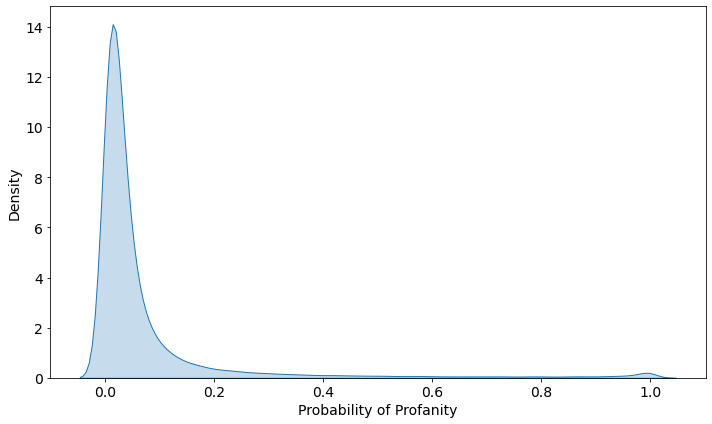

In [94]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(post_profanity_probs, ax=ax, fill=True)
ax.set_xlabel("Probability of Profanity", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.tight_layout()
plt.show()

In [95]:
fe_avg_profanity_prob = post_profanity_probs[post_profanity_probs.index.isin(fe_posts.index)].mean()
fe_profanity_proportion = post_profanity[post_profanity.index.isin(fe_posts.index)].mean()

ot_avg_profanity_prob = post_profanity_probs[post_profanity_probs.index.isin(ot_posts.index)].mean()
ot_profanity_proportion = post_profanity[post_profanity.index.isin(ot_posts.index)].mean()

In [96]:
print(f"Overall average profanity probability:\t\t\t{post_profanity_probs.mean() * 100:.2f}%")
print(f"Average profanity probability in Flat Earth Boards:\t{fe_avg_profanity_prob * 100:.2f}%")
print(f"Average profanity probability in Off-Topic Boards:\t{ot_avg_profanity_prob * 100:.2f}%")
print()
print(f"Overall average profanity proportion:\t\t\t{post_profanity.mean() * 100:.2f}%")
print(f"Average profanity proportion in Flat Earth Boards:\t{fe_profanity_proportion * 100:.2f}%")
print(f"Average profanity proportion in Off-Topic Boards:\t{ot_profanity_proportion * 100:.2f}%")

Overall average profanity probability:			7.66%
Average profanity probability in Flat Earth Boards:	4.01%
Average profanity probability in Off-Topic Boards:	12.85%

Overall average profanity proportion:			3.76%
Average profanity proportion in Flat Earth Boards:	0.85%
Average profanity proportion in Off-Topic Boards:	7.86%


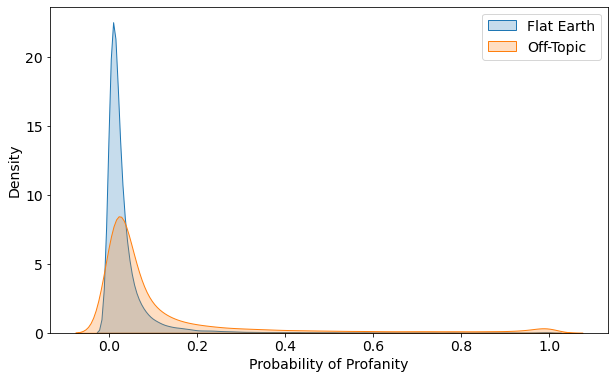

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(post_profanity_probs[post_profanity_probs.index.isin(fe_posts.index)], ax=ax, fill=True, label="Flat Earth")
sns.kdeplot(post_profanity_probs[post_profanity_probs.index.isin(ot_posts.index)], ax=ax, fill=True, label="Off-Topic")
ax.legend(fontsize=14)
ax.set_xlabel("Probability of Profanity", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
fig.savefig(os.path.join(GRAPH_DIR, "Profanity_Density.pdf"))
plt.show()

In [98]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(post_profanity_probs[post_profanity_probs.index.isin(fe_posts.index)], 
                       post_profanity_probs[post_profanity_probs.index.isin(ot_posts.index)])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=1073935832.000, p=0.000
Probably different distributions


### Profanity over time

In [99]:
# Set a dummy variable for counting in the rolling window
fe_posts.loc[:,"flag"] = [True] * len(fe_posts)
ot_posts.loc[:,"flag"] = [True] * len(ot_posts)

c:\users\eddie\documents\language-change-application\env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\eddie\documents\language-change-application\env\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


#### Rolling average of profanity

In [100]:
fe_posts.loc[:, "profanity_prob"] = post_profanity_probs.loc[fe_posts.index]
ot_posts.loc[:, "profanity_prob"] = post_profanity_probs.loc[ot_posts.index]

In [101]:
rolling_profanity_prob = fe_posts.rolling("90D", on="time")["profanity_prob"].mean()

In [102]:
MAIN_COLOUR = "#7fc97f"
SECOND_COLOUR = "#beaed4"

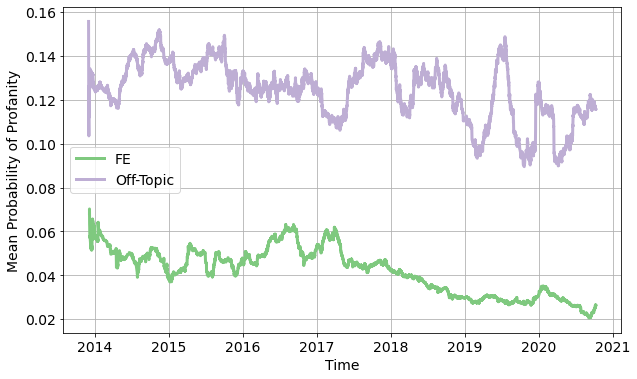

In [103]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(fe_posts["time"], fe_posts.rolling("90D", on="time", min_periods=100)["profanity_prob"].mean(), 
        color=MAIN_COLOUR, lw=3, label="FE")
ax.plot(ot_posts["time"], ot_posts.rolling("90D", on="time", min_periods=100)["profanity_prob"].mean(), 
        color=SECOND_COLOUR, lw=3, label="Off-Topic")
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Mean Probability of Profanity", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()
ax.legend(fontsize=14)
fig.savefig(os.path.join(GRAPH_DIR, "profanity_prob_over_time.pdf"))
plt.show()

#### Number of profane posts over time

In [104]:
%%time
fe_profan_over_time = dict()
for window, w_posts in get_time_windows(fe_posts, 180, 90):
    fe_profan_over_time[window] = post_profanity[post_profanity.index.isin(w_posts.index)].mean() * 100
fe_profan_over_time = pd.Series(fe_profan_over_time)

off_topic_profan_over_time = dict()
for window, w_posts in get_time_windows(ot_posts, 180, 90):
    off_topic_profan_over_time[window] = post_profanity[post_profanity.index.isin(w_posts.index)].mean() * 100
off_topic_profan_over_time = pd.Series(off_topic_profan_over_time)

Wall time: 18.2 s


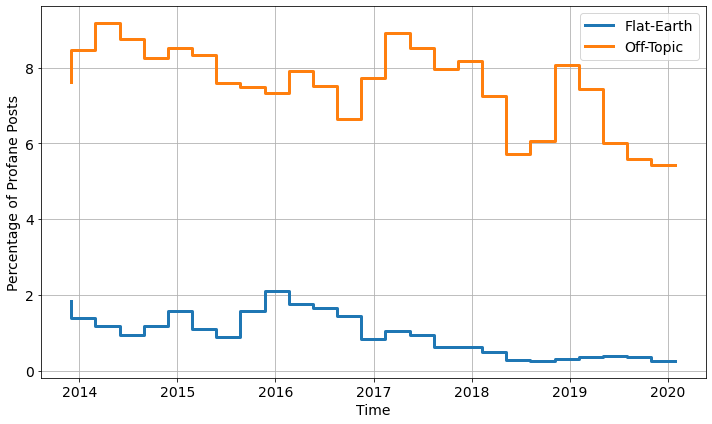

In [105]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(fe_profan_over_time.index, fe_profan_over_time.values, drawstyle='steps-pre', label='Flat-Earth', lw=3)
ax.plot(off_topic_profan_over_time.index, off_topic_profan_over_time.values, drawstyle='steps-pre', label='Off-Topic', lw=3)
ax.legend(fontsize=14)
ax.set_ylabel("Percentage of Profane Posts", fontsize=14)
ax.set_xlabel("Time", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid()
plt.tight_layout()
fig.savefig(os.path.join(GRAPH_DIR, "Percentage_Profanity_Over_Time.pdf"))
plt.show()